# Exploration_14

## 1. DCGAN

### 1.1 Module

- 사용할 패키지를 설치합니다.

In [53]:
! pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
! pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
!pip install keras-rectified-adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8270 sha256=475099630ac4dfffa40837d41152622b6ce053c9a5ae0045b4642bf0d59ee1be
  Stored in directory: /root/.cache/pip/wheels/5d/1f/40/3fe78c6f4dd6f0522c558077283361e7d50fd7720d2f8fcd7e
Successfully built keras-rectified-adam


In [56]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.3 MB/s 


In [71]:
import os
import glob
import time
import cv2
from PIL import Image
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras_radam import RAdam
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from google.colab import drive
from google.colab.patches import cv2_imshow

%matplotlib inline

### 1.2 Image

#### 1.2.1 Image load

In [72]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


- 이미지의 카테고리를 나타내는 label은 필요하지 않습니다.  
그래서 underscore로 무시하고 필요한 것만 가져옵니다.

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

- (32, 32, 3) 크기입니다.  
일단 픽셀 max, min을 찍어보고 정규화를 해줍니다.

In [ ]:
print(train_x.max())
print(train_x.min())

255
0


In [ ]:
train_x = (train_x - 127.5) / 127.5
print(train_x.max())
print(train_x.min())

1.0
-1.0


- 어떤 이미지로 구성되어 있는지 궁금합니다 몇개만 찍어봅니다.

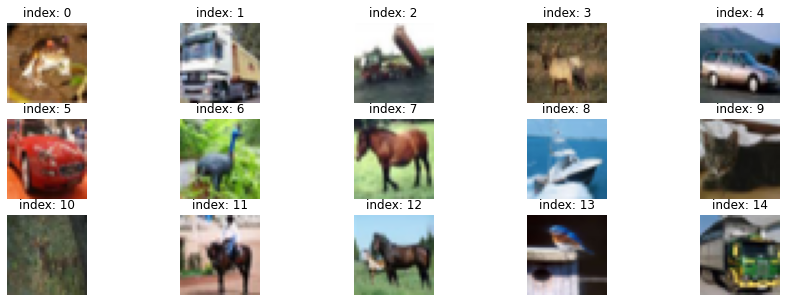

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow((train_x[i] + 1)/2 , cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

- 차, 보트, 말, 새 등이 있습니다.

### 1.3 Default Model

#### 1.3.1 Generator Model

- generator model을 생성합니다.
- 이 모델의 layer는 뒤에 있을 다양한 모델의 default 값이 됩니다.

In [ ]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

- dense, reshape, conv2Dtraspose의 형태로 쌓았습니다.
- summary를 찍으면 확인할 수 있지만, outshape가 (32, 32, 3)으로 나옵니다.

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1638400   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

- parameter가 약 410만개 정도입니다.

- output과 같은 크기로 noise도 생성해줍니다.

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

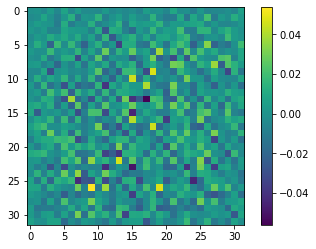

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

- 다음으로 넘어갑니다.

#### 1.3.2 Discriminator Model

- 이번에는 discriminator model을 만듭니다.
- generator model과 마찬가지로 이 모델의 layer는 뒤에 있을 다양한 모델의 default 값이 됩니다.

In [ ]:
def make_discriminator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1))
    
    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

- 약 100만개의 parameter가 있습니다.

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00222204]], dtype=float32)>

#### 1.3.3 Loss Function

- 손실 함수를 정의합니다.  
fake와 real을 구분해야 하므로 이진 교차 엔트로피를 사용합니다.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### 1.3.4 Generator loss

- generator loss는 만들어낸 fake가 1에 가까워져야하는 목표를 가지고 있으므로  
fake output과 같은 shape인 tf.ones_like와의 교차 엔트로피를 계산합니다.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### 1.3.5 Discriminator loss

- discriminator loss는 real이 1, fake가 0이어야 합니다.  
real output과, fake output의 같은 shape의 0벡터와 비교하여 두 값을 더해줍니다.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### 1.3.6 Discriminator accuracy

- tf.math.greater_equal로 output이 tf.constant([0.5])보다 높으면 True, 아니면 False 값을 줍니다.  
그다음 tf.cast로 True면 1.0, False면 0.0으로 바꿔줍니다  
tf.reduce_mean 으로 평균내서 accuracy를 계산합니다.  
이 과정은 real output과 fake output만 다르고 나머지는 같습니다.

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### 1.3.7 Train setting

##### 1) Optimizer

- Generator와 Discriminator가 따로 학습하는 구조이므로 Optimizer도 따로 만듭니다.  
- Optimizer를 바꿔가며 결과물을 확인할 수 있을 것 같습니다.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##### 2) Sample

- Generator의 학습 진행 확인을 위한 샘플을 생성합니다.  
dim=100의 noise를 16개(16, 100) shape의 벡터입니다.

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

##### 3) Dataset

- batch 사이즈를 설정하고 dataset을 만듭니다.

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##### 4) Train step

- @tf.function 데코레이터를 통해 텐서플로 1.x 때처럼 그래프 생성과 실행을 분리해줍니다.  
- image를 입력받아 같은 세크와 크기로 noise를 생성,  
미분계산을 위한 with 구문을 통해 generator가 image를 생성, discriminator가 image를 판별합니다.  
다음 loss, accuracy 함수를 통해 loss, accuracy 값을 계산합니다.  
gradient 계산 후 weight 갱신하고 loss, accuracy를 리턴해줍니다.

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # (1) 이미지 생성 from noise
        generated_images = generator(noise, training=True)
        # (2) 실제 이미지와 (1)에서 생성된 이미지를 판별 
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        # (3) 생성한 이미지를 (2)에서 검사받고 그에 대한 loss 계산
        gen_loss = generator_loss(fake_output)
        # (4) 실제 이미지와 생성 이미지에 대해 판별 loss 게산
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

##### 5) Generate and save images

- 샘플을 (4, 4) 총 16개를 받아서 확인하고 저장합니다.

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    # np_predictions = predictions.numpy()
    # np_predictions = (np_predictions * 127.5) + 127.5 # 정규화 했던 것을 되돌리기
    # np_predictions = np_predictions.astype(int)
    
    fig = plt.figure(figsize=(4, 4))  # 16장 샘플을 보기로 했다. 
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8')) # plt는 2차원만 볼 수 있다. 
        plt.axis('off')
    
    plt.savefig('/gdrive/My Drive/Colab Notebooks/DCGAN/generate/epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.show()

##### 6) Draw train history

- loss와 accuracy를 시각화하고 저장합니다.

In [ ]:
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 크기 설정

def draw_train_history(history, epoch):
    # loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])    
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='lower left')
    
    # 그래프를 이미지로 저장 
    plt.savefig('/gdrive/My Drive/Colab Notebooks/DCGAN/history/train_history_{:04d}.png'.format(epoch))
    plt.show()

##### 7) Checkpoint 

- checkpoint를 저장하기 위해 설정합니다.  
generator와 discriminator 그리고 각각의 optimizer를 저장합니다.


In [ ]:
checkpoint_dir = '/gdrive/My Drive/Colab Notebooks/DCGAN/checkpoint/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

##### 8) train setting

- train을 수행하기 전 준비를 합니다.

In [ ]:
  def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)            
            history['real_accuracy'].append(real_accuracy)            
            history['fake_accuracy'].append(fake_accuracy)  
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        if (epoch+1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for trining : {}sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)

- Default epochs 입니다.

In [ ]:
save_every = 10
EPOCHS = 300

#### 1.3.8 Train

- gpu를 적극 이용합니다.

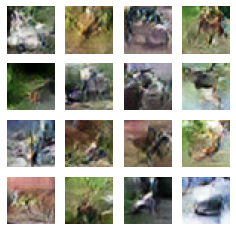

Time for trining : 9557sec


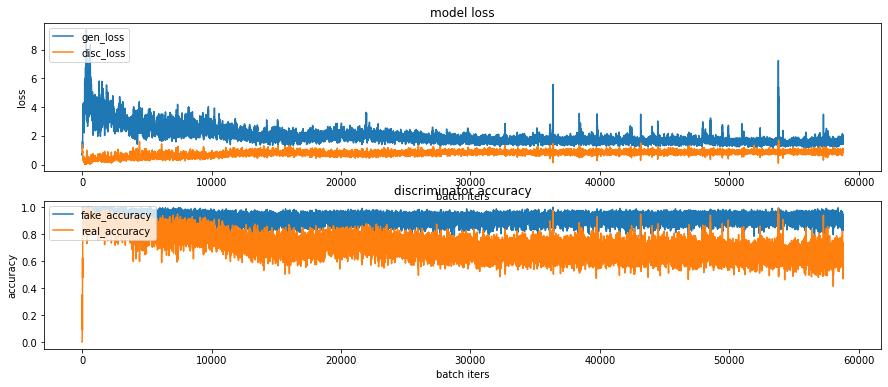

CPU times: user 2h 40min 16s, sys: 1min 32s, total: 2h 41min 48s
Wall time: 2h 39min 20s


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 이상적인 수치는 fake = 0.5, real = 0.5 수준이어야 하는데 생각보다 떨어지지 않습니다.

#### 1.3.9 Visualization

- imageio로 생성 이미지를 gif로 만들어줍니다.

In [ ]:
anim_file = '/gdrive/My Drive/Colab Notebooks/DCGAN/gif_file/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/gdrive/My Drive/Colab Notebooks/DCGAN/generate/epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

[Errno 20] Not a directory: '/gdrive/My Drive/Colab Notebooks/DCGAN/gif_file/cifar10_dcgan.gif'
/content


### 1.4 Learning Rate

- Learning rate에 따른 변화를 살펴봅니다.
- 1e-4를 기준(Default)으로 1e-3, 1e-5를 비교합니다.

#### 1.4.1 Adam Optimizer (learning_rate=1e-3)

- 기존 모든 값들은 동일합니다.
- leaning_rate만 1e-3입니다.

##### 1) Layer

In [ ]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1638400   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0022324]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

##### 5) Train

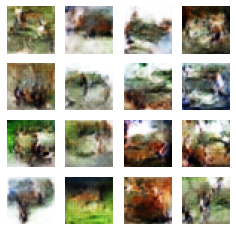

Time for trining : 9447sec


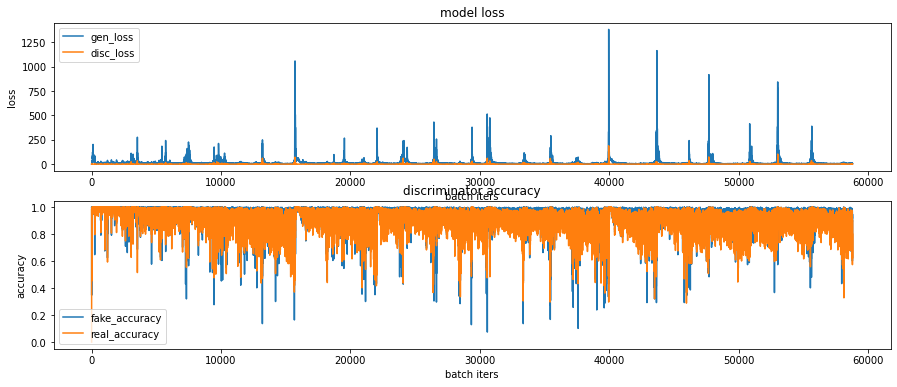

CPU times: user 2h 35min 54s, sys: 1min 11s, total: 2h 37min 6s
Wall time: 2h 37min 30s


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 거의 변화가 없습니다.

#### 1.4.2 Adam Optimizer (learning_rate=1e-5)

- 기존 모든 값들은 동일합니다.
- learning_rate만 1e-5입니다.

##### 1) Layer

In [ ]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1638400   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00090469]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

##### 5) Train

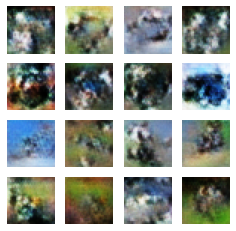

Time for trining : 9393sec


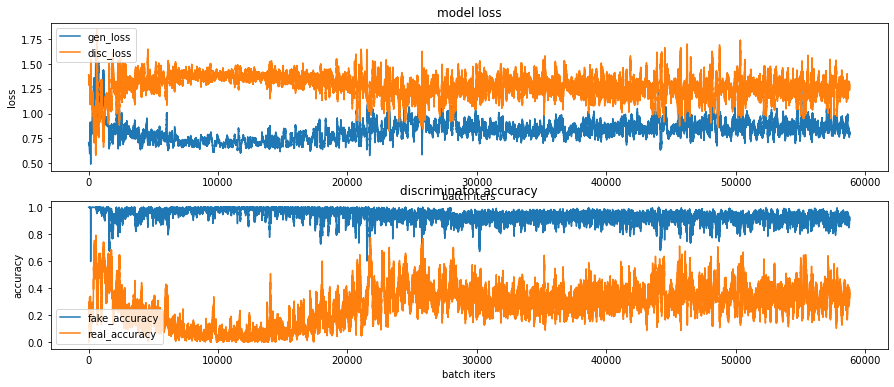

CPU times: user 2h 36min 12s, sys: 1min 10s, total: 2h 37min 23s
Wall time: 2h 36min 36s


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- real, fake의 차이가 큰 부분이 인상적입니다만, 여기도 이상적인 0.5, 0.5는 아닙니다.

### 1.5 Optimizer

- Optimizer에 따른 변화를 살펴봅니다.
- Adam(Default), Nadam, AdamW, Radam을 비교합니다.  
(learning_rate=1e-4 동일)

#### 1.5.1 Nadam Optimizer (learning_rate=1e-4)

- Optimizer는 Nadam입니다.

##### 1) Layer

In [ ]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00020975]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
discriminator_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

##### 5) Train

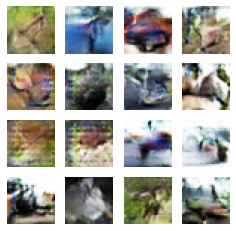

Time for trining : 9327sec


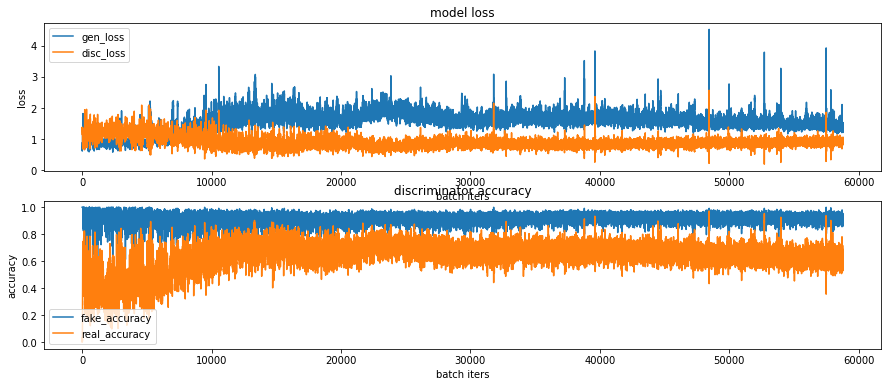

CPU times: user 2h 36min 58s, sys: 7min 44s, total: 2h 44min 42s
Wall time: 2h 35min 31s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

- 결과는 아래에서 다루겠습니다.

#### 1.4.4 AdamW Optimizer (learning_rate=1e-4)

- Optimizer는 AdamW입니다.

##### 1) Layer

In [ ]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1638400   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00141644]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
discriminator_optimizer = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

##### 5) Train

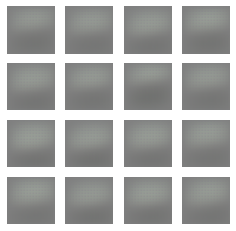

Time for trining : 9202sec


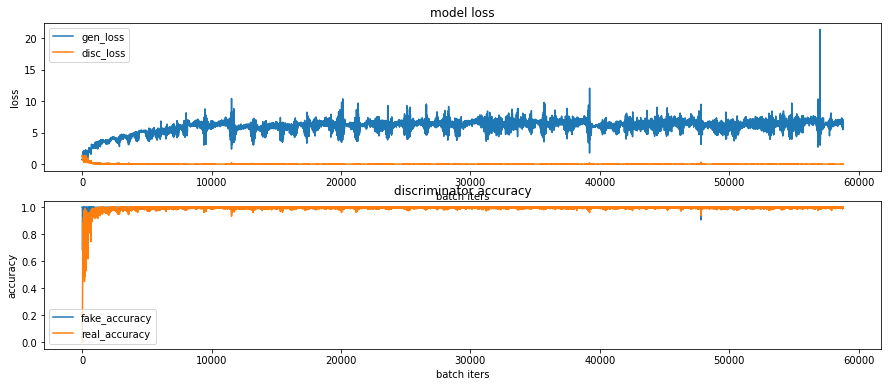

CPU times: user 2h 33min 11s, sys: 1min 12s, total: 2h 34min 24s
Wall time: 2h 33min 25s


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 처참합니다... 결과는 아래에서 다루겠습니다.

#### 1.4.5 Radam Optimizer (learning_rate=1e-4)

- Optimizer는 Radam입니다.

##### 1) Layer

In [ ]:
def make_generator_model():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1638400   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)        1

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0001112]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = RAdam(total_steps=300, learning_rate=1e-4, warmup_proportion=0.1, min_lr=1e-5)
discriminator_optimizer = RAdam(total_steps=300, learning_rate=1e-4, warmup_proportion=0.1, min_lr=1e-5)

##### 5) Train

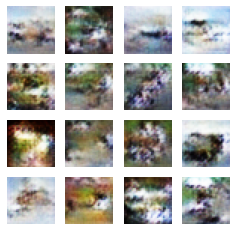

Time for trining : 9795sec


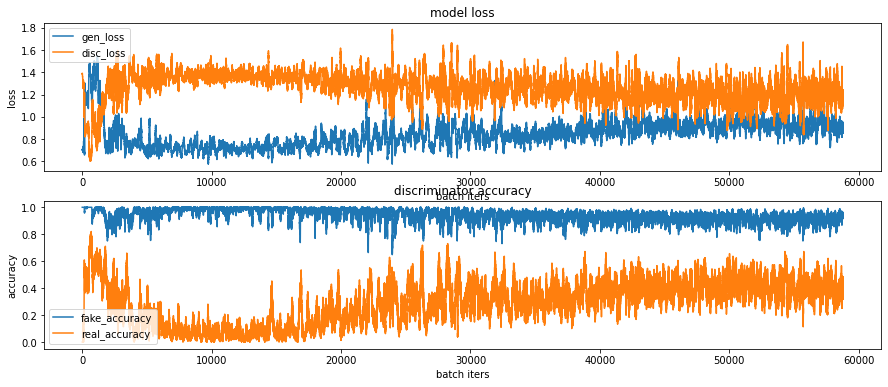

CPU times: user 2h 43min 9s, sys: 1min 25s, total: 2h 44min 34s
Wall time: 2h 43min 18s


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 결과는 아래에서 다루겠습니다.

### 1.6 Add_Layer

- Layer를 추가로 쌓아 비교해봅니다.
- 추가한 layer를 고정한 상태에서 Optimizer와 learning rate의 변화를 줍니다.
- Optimizer는 결과가 나쁘지 않았던 Adam과 Nadam을 사용합니다.

#### 1.6.1 Add_layer(Adam, 1e-4)

- 기존 generator layer에 Conv2D layer를 추가했습니다. 
- Conv2DTranspose filter 값을 128로 내리고, strides로 output shape를 맞췄습니다.
- Discriminator layer에도 Conv2D layer를 추가했습니다.
- 이외 다른 모든 조건은 동일합니다.

##### 1) Layer

In [ ]:
def make_generator_model_1():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model_1():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model_1()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         819328    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                        

In [ ]:
discriminator = make_discriminator_model_1()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4999858]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##### 5) Train

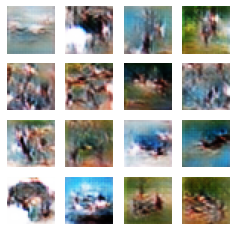

Time for trining : 11049sec


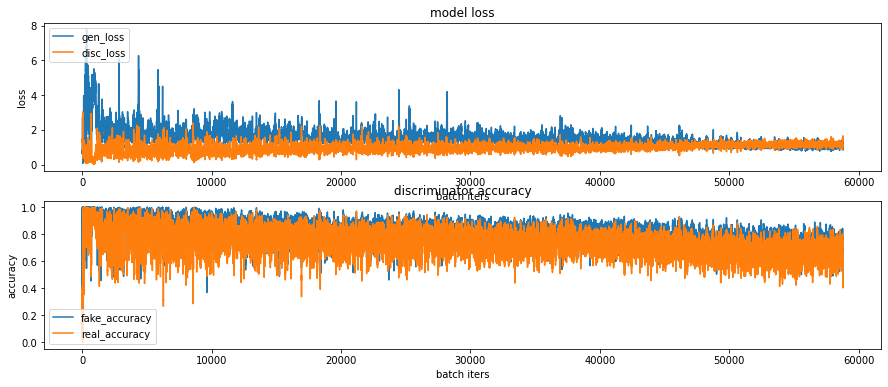

CPU times: user 3h 3min 57s, sys: 1min 24s, total: 3h 5min 22s
Wall time: 3h 4min 12s


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 결과는 아래에서 다루겠습니다.

#### 1.6.2 Add_layer(Adam, 1e-5)

- 기존 generator layer에 Conv2D layer를 추가했습니다. 
- Conv2DTranspose filter 값을 128로 내리고, strides로 output shape를 맞췄습니다.
- Discriminator layer에도 Conv2D layer를 추가했습니다.
- 이번에는 learning_rate의 값을 1e-5로 수정했습니다.

##### 1) Layer

In [ ]:
def make_generator_model_1():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model_1():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model_1()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         819328    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                        

In [ ]:
discriminator = make_discriminator_model_1()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4999858]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

##### 5) Train

In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 시간상 여러 계정을 통해 모델을 돌리고 가져왔습니다.

In [3]:
insert_img_21 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/aa-5i.png'
insert_img_21 = cv2.imread(insert_img_21)
insert_img_22 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/aa-5.png'
insert_img_22 = cv2.imread(insert_img_22)

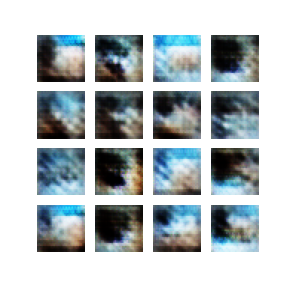

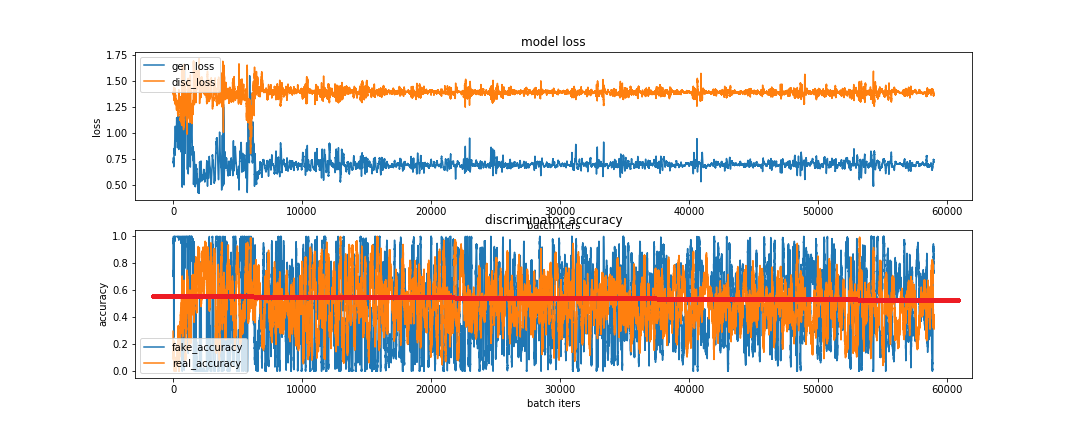

In [4]:
cv2_imshow(insert_img_21)
cv2_imshow(insert_img_22)

- 결과는 아래에서 다루겠습니다.

#### 1.6.3 Add_layer(Nadam, 1e-4)

- 기존 generator layer에 Conv2D layer를 추가했습니다. 
- Conv2DTranspose filter 값을 128로 내리고, strides로 output shape를 맞췄습니다.
- Discriminator layer에도 Conv2D layer를 추가했습니다.
- 이번에는 Nadam에 learning_rate는 1e-4입니다.

##### 1) Layer

In [ ]:
def make_generator_model_1():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model_1():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model_1()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         819328    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                        

In [ ]:
discriminator = make_discriminator_model_1()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4999858]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##### 5) Train

In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 시간상 다른 계정에서 모델을 돌리고 결과를 가져왔습니다.

In [5]:
insert_img_23 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/an-4i.png'
insert_img_23 = cv2.imread(insert_img_23)
insert_img_24 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/an-4.png'
insert_img_24 = cv2.imread(insert_img_24)

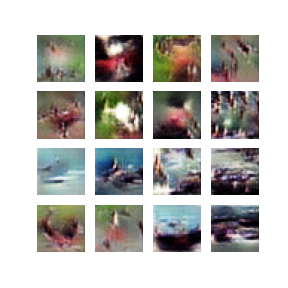

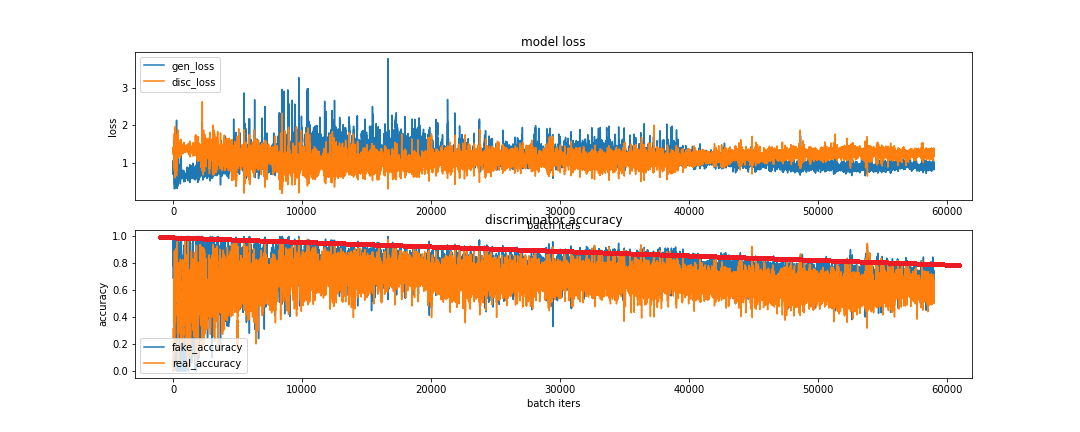

In [6]:
cv2_imshow(insert_img_23)
cv2_imshow(insert_img_24)

- 결과는 아래에서 다루겠습니다.

#### 1.6.4 Add_layer(Nadam, 1e-5)

- 기존 generator layer에 Conv2D layer를 추가했습니다. 
- Conv2DTranspose filter 값을 128로 내리고, strides로 output shape를 맞췄습니다.
- Discriminator layer에도 Conv2D layer를 추가했습니다.
- 이외 다른 모든 조건은 동일합니다.
- 이번에는 Nadam에 learning_rate는 1e-5입니다.

##### 1) Layer

In [ ]:
def make_generator_model_1():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model_1():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model_1()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 128)         819328    
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                        

In [ ]:
discriminator = make_discriminator_model_1()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 128)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4999858]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 10
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##### 5) Train

In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 시간상 다른 계정에서 모델을 돌리고 결과를 가져왔습니다.

In [7]:
insert_img_25 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/an-5i.png'
insert_img_25 = cv2.imread(insert_img_25)
insert_img_26 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/an-5.png'
insert_img_26 = cv2.imread(insert_img_26)

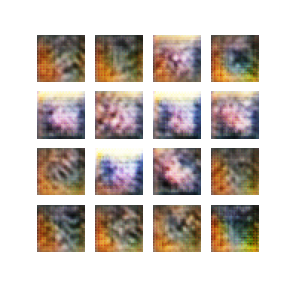

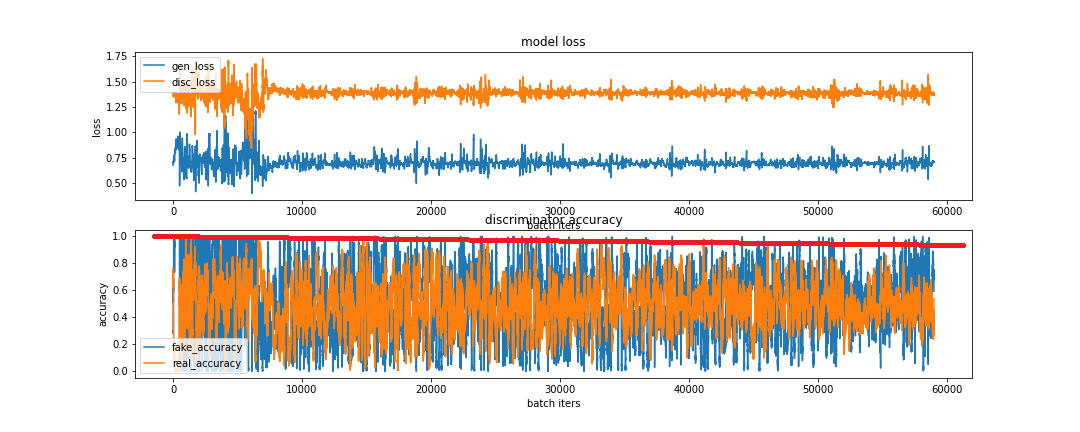

In [8]:
cv2_imshow(insert_img_25)
cv2_imshow(insert_img_26)

- 결과는 아래에서 다루겠습니다.

### 1.7 Epochs

#### 1.7.1 Epochs 1000(Adam, 1e-4)

##### 1) Layer

In [ ]:
def make_generator_model_2():
    # start
    model = tf.keras.Sequential()
    
    # First : Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second : Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Third : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third : Conv2DTranspose layer
    model.add(layers.Conv2D(128, (5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth : Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
def make_discriminator_model_2():
    
    # start
    model = tf.keras.Sequential()
    
    # First : Conv2D layer
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # First : Conv2D layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second : Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third : Conv2D 
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fourth : Flatten layer
    model.add(layers.Flatten())
    
    # Fifth : Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

##### 2) Summary

In [ ]:
generator = make_generator_model_2()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         819328    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                      

In [ ]:
discriminator = make_discriminator_model_2()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        2432      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)        

##### 3) Setting

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49992347]], dtype=float32)>

##### 4) Train Setting

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
save_every = 100
EPOCHS = 300

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##### 5) Train

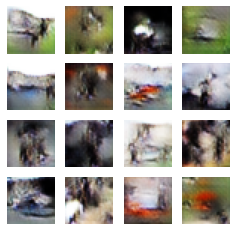

Epoch 365 | iter 151
Time for epoch 365 : 26 sec


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 도중에 runtime이 끊겨 epoch 300에서 끊고 나머지를 다시 진행합니다.

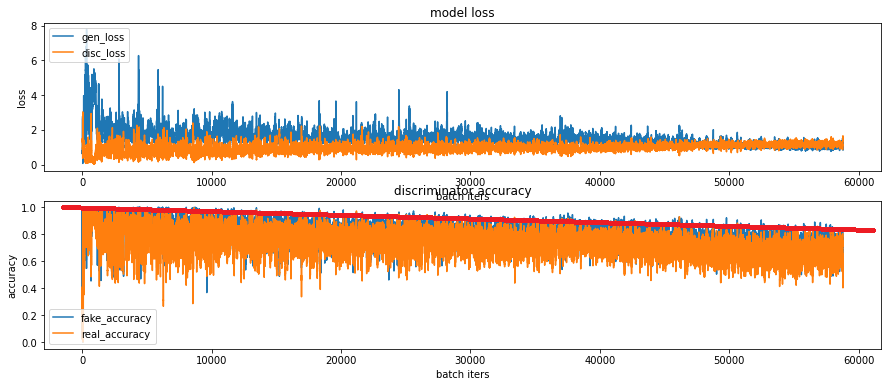

In [9]:
insert_img_27 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/aae-4.png'
insert_img_27 = cv2.imread(insert_img_27)
cv2_imshow(insert_img_27)

##### 6) Check Point

- checkpoint를 활용해 epoch 300까지 훈련된 모델을 다시 불러와 나머지 700을 진행합니다.

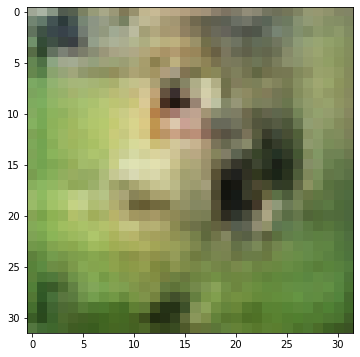

In [ ]:
checkpoint_dir = '/gdrive/My Drive/Colab Notebooks/DCGAN/checkpoint/training_checkpoints_2'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
save_every = 100
EPOCHS = 700

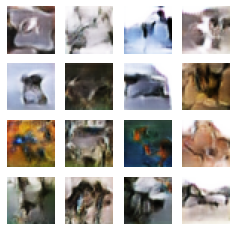

Time for trining : 16490sec


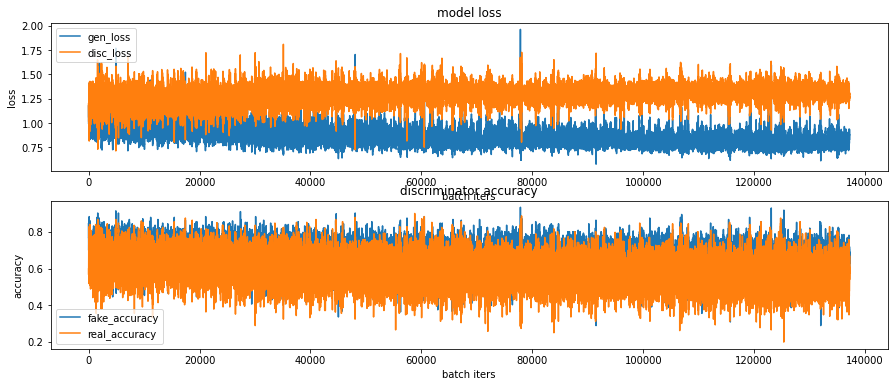

CPU times: user 4h 27min 59s, sys: 2min 41s, total: 4h 30min 40s
Wall time: 4h 34min 56s


In [ ]:
%%time
with tf.device('/GPU:0'):   # or ('/device:GPU:0')
    train(train_dataset, EPOCHS, save_every)

- 결과는 아래에서 다루겠습니다.

In [ ]:
anim_file = '/gdrive/My Drive/Colab Notebooks/DCGAN/gif_file/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/gdrive/My Drive/Colab Notebooks/DCGAN/generate_2/epoch*.gif')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

- 추가로 생성 image의 변화를 확인하기 위해 gif로 만듭니다.

### 1.8 Compare

- 위에서 진행한 과정을 비교해봅니다.

#### 1.8.1 Learning Rate

- Learning rate 차이에 따른 변화를 살펴봅니다.

In [10]:
insert_img_5 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/a-3.png'
insert_img_5 = cv2.imread(insert_img_5)
insert_img_6 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/a-4.png'
insert_img_6 = cv2.imread(insert_img_6)
insert_img_7 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/a-5.png'
insert_img_7 = cv2.imread(insert_img_7)

##### 1) Learning_rate = 1e-3

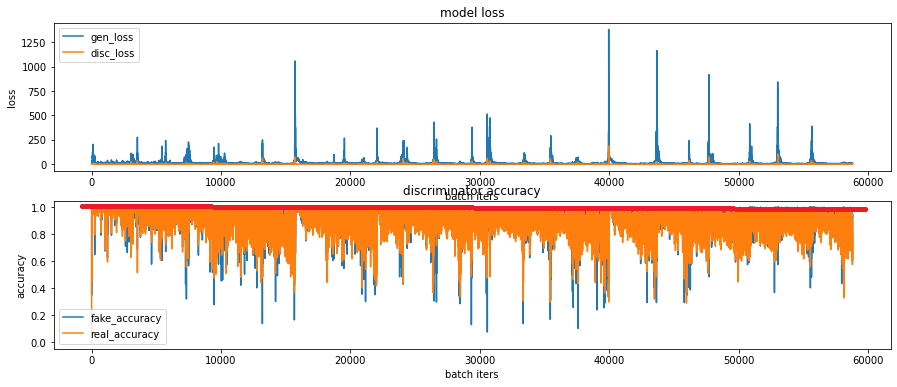

In [11]:
cv2_imshow(insert_img_5)

##### 2) Learning_rate = 1e-4

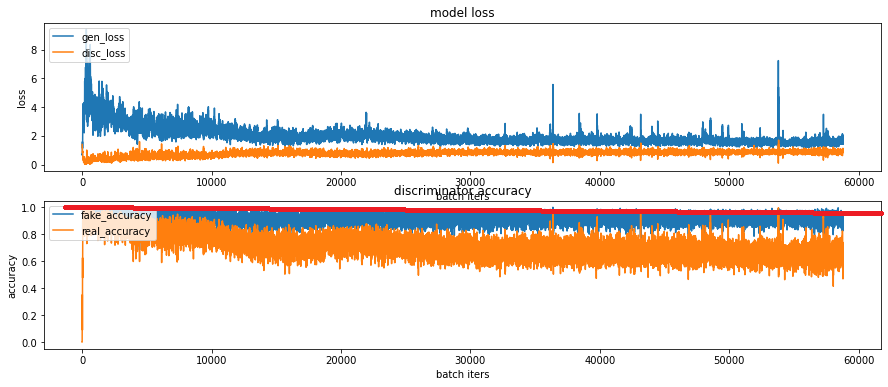

In [12]:
cv2_imshow(insert_img_6)

##### 3) Learning_rate = 1e-5

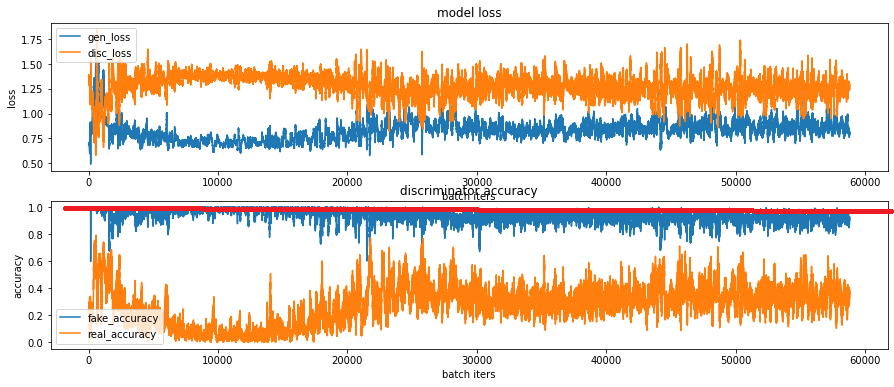

In [13]:
cv2_imshow(insert_img_7)

##### 4) Conclusion

- 1e-3은 학습 자체가 거의 이뤄지지 않습니다. global minima를 찾아가지 못하는 것 같습니다.  
(loss가 1000 넘게 올라가는걸 보니 유독 그런 것 같습니다.)  
- 1e-4와 1e-5는 fake_acc에서 차이가 거의 없지만, real_acc에서의 차이가 있습니다.  
이는 discriminator가 진짜를 잘 판별하지 못하는 것 같습니다. loss 값도 real_loss가 더 높습니다.

#### 1.8.2 Optimizer

- Optimizer 차이에 따른 변화를 살펴봅니다.

In [14]:
insert_img_8 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/a-4.png'
insert_img_8 = cv2.imread(insert_img_8)
insert_img_9 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/n-4.png'
insert_img_9 = cv2.imread(insert_img_9)
insert_img_10 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/r-4.png'
insert_img_10 = cv2.imread(insert_img_10)
insert_img_11 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/w-4.png'
insert_img_11 = cv2.imread(insert_img_11)

##### 1) Adam

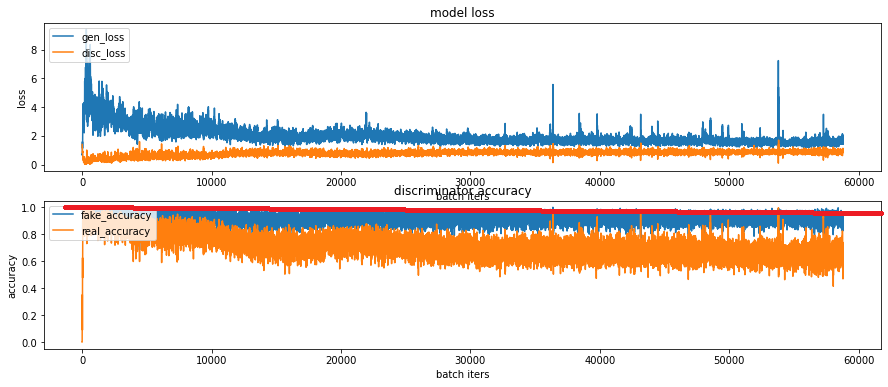

In [15]:
cv2_imshow(insert_img_8)

##### 2) Nadam

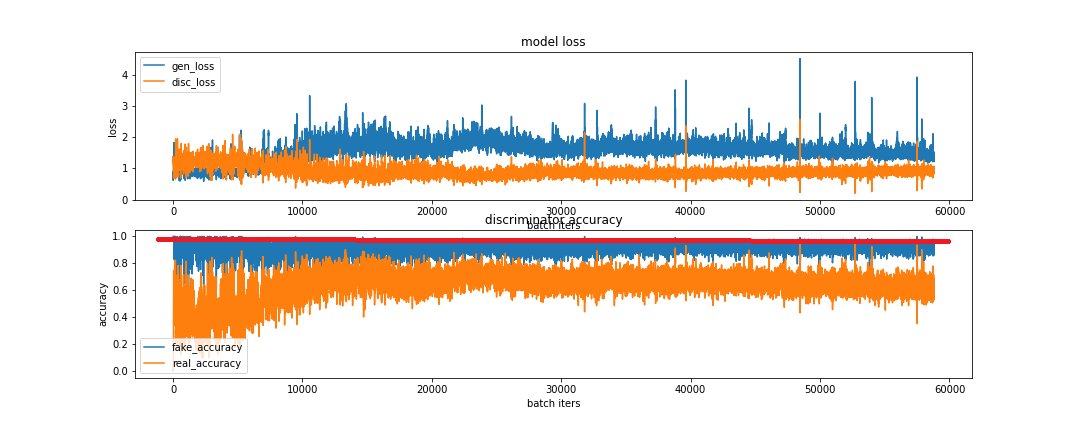

In [16]:
cv2_imshow(insert_img_9)

##### 3) Radam

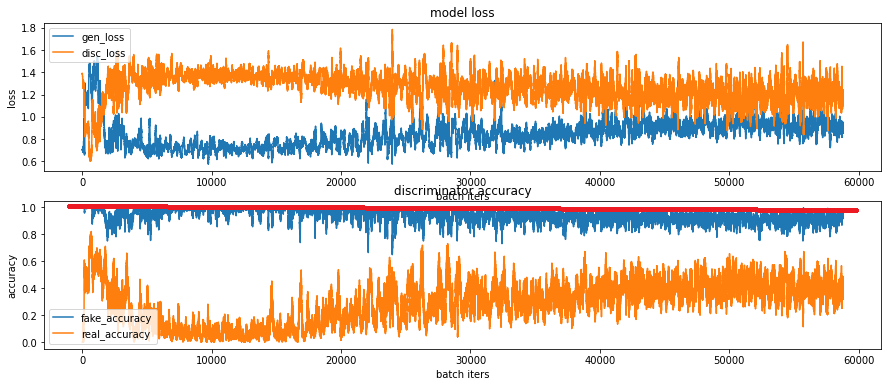

In [17]:
cv2_imshow(insert_img_10)

##### 4) AdamW

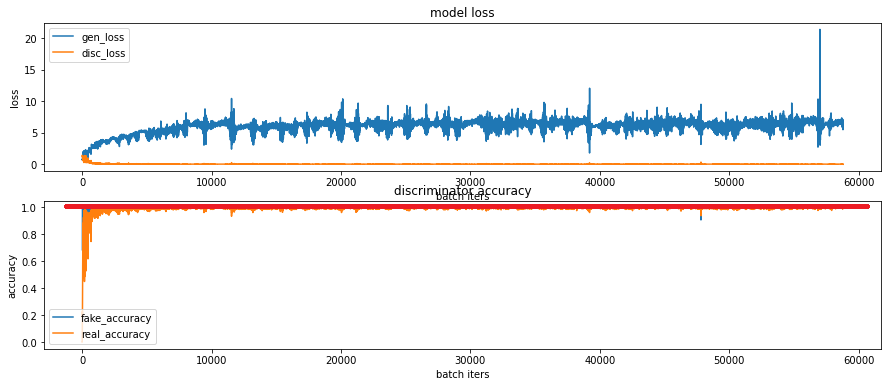

In [18]:
cv2_imshow(insert_img_11)

##### 5) Conclusion

- AdamW는 글렸습니다...
- Adam, Nadam, Radam은 Loss 값도 같이 비교해보면 좋을 것 같습니다.
특히 Radam, Nadam이 loss 값이 낮은 경향을 보이는데 Adam보다 시간은 더 걸릴지언정 이상적인 accuracy 수치인 0.5, 0.5에 더 근접할 수 있을 것 같습니다.
- 사실 accuracy도 그렇게 차이 나는 것도 아닌 것 같습니다...

#### 1.8.3 Layer

- Layer를 추가함에 따른 변화를 살펴봅니다.
- 크게 Adam, Nadam optimizer로 나눠 Default, Add_layer로 비교합니다.

In [20]:
insert_img_12 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/n-4.png'
insert_img_12 = cv2.imread(insert_img_12)
insert_img_13 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/an-4.png'
insert_img_13 = cv2.imread(insert_img_13)
insert_img_14 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/a-4.png'
insert_img_14 = cv2.imread(insert_img_14)
insert_img_15 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/aa-4.png'
insert_img_15 = cv2.imread(insert_img_15)

##### 1) Adam(Default)

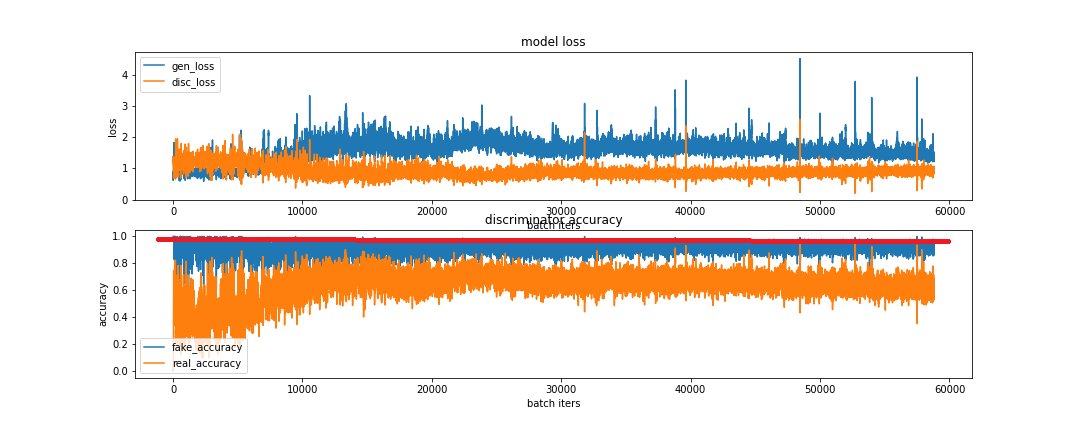

In [21]:
cv2_imshow(insert_img_12)

##### 2) Adam(Add_layer)

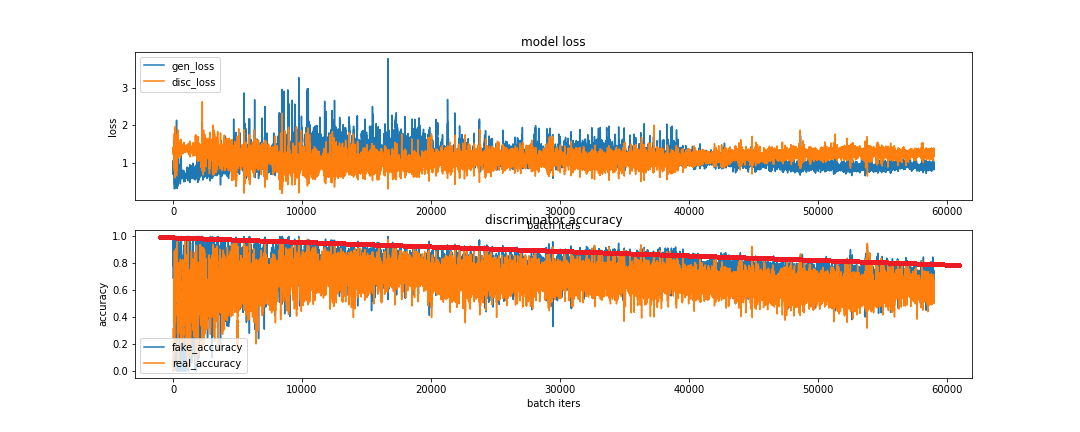

In [22]:
cv2_imshow(insert_img_13)

##### 3) Nadam(Default)

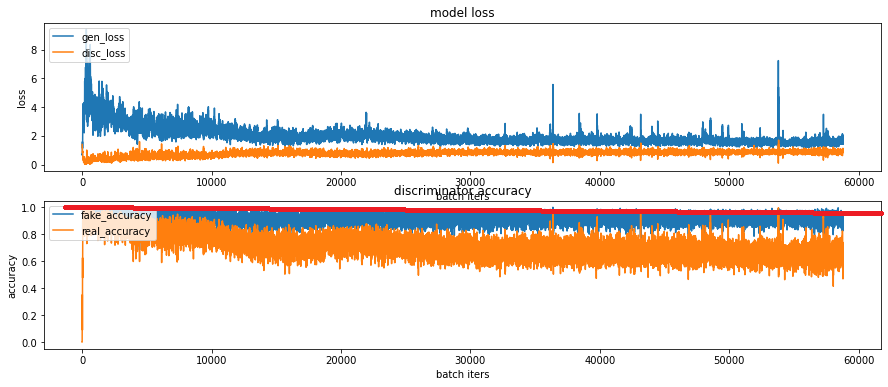

In [23]:
cv2_imshow(insert_img_14)

##### 4) Nadam(Add_layer)

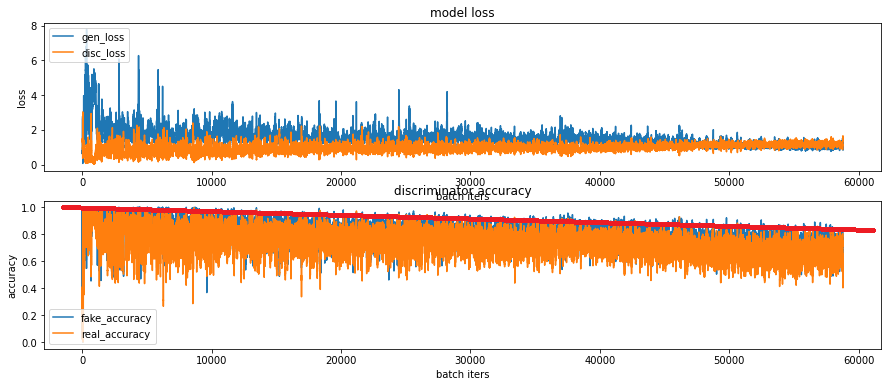

In [24]:
cv2_imshow(insert_img_15)

##### 5) Conclusion

- 확실히 Adam, Nadam 모두 optimizer보다는 layer의 영향을 많이 받습니다.  
- layer를 추가하고 변화를 줬을 때 loss 값의 큰 변동은 없으나 accuracy에서 눈에 띄게 우하향 하는 모습을 보여줍니다.

#### 1.8.4 Epochs

In [30]:
insert_img_16 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/aa-4.png'
insert_img_16 = cv2.imread(insert_img_16)
insert_img_17 = '/gdrive/My Drive/Colab Notebooks/DCGAN/results/graph/aae-4_2.png'
insert_img_17 = cv2.imread(insert_img_17)

##### 1) Epoch 300

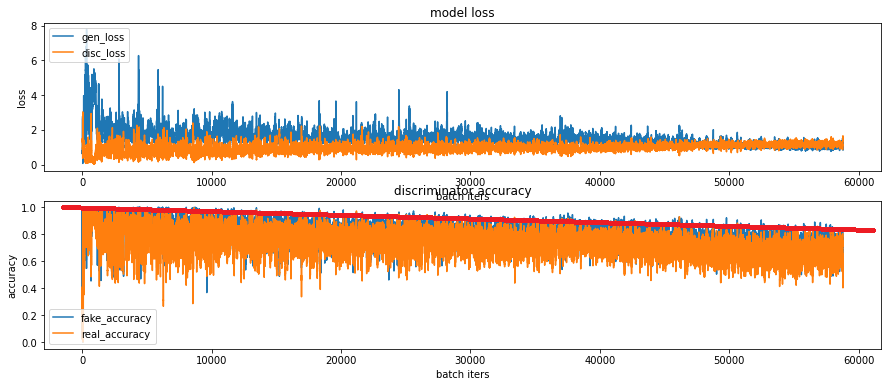

In [31]:
cv2_imshow(insert_img_16)

##### 2) Epoch 300 ~ 1000

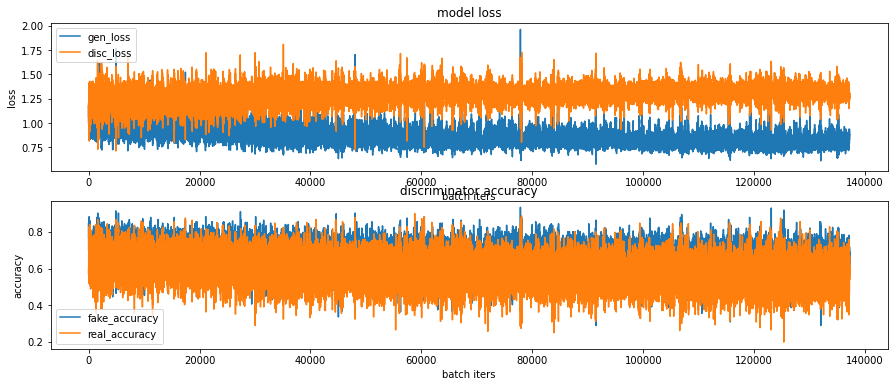

In [32]:
cv2_imshow(insert_img_17)

##### 3) Conclusion

- 그래프를 이어서 확인했으면 더 아름다웠을텐데...  
- fake_loss 값도 우하향 추세를 보여줍니다.
- epoch을 약 5,000까지 돌려주면 이상적인 수치에 접근할 수 있을 것 같습니다.  
- 위 결과를 토대로 Nadam optimizer도 비슷한 추세를 보여줄 것 같습니다.


- layer를 추가하고 Adam 또는 Nadam 차선으로 Radam까지 optimizer를 활용,  
 learning rate를 1e-4 수준에서 주어 epoch 1,000 이상 학습하면 좋은 결과를 찾을 수 있습니다.

##### 4) gif

- gif는 용량상 아래 링크로 확인할 수 있습니다. 
- 문제는 제일 잘 나온 Add_layer, Adam optimizer, learning_rate=1e-4, epochs=1000 모델을 바탕으로 했습니다만  
runtime으로 인해 중간에 끊고 다시 돌리는 과정에서 기존 epoch 300까지 결과를 덮어 써버렸습니다...  
- 300~1000까지만 보겠습니다.

- https://drive.google.com/file/d/1-0CyTUsdLoCVtTHiECOeJUF9hIIe2-uF/view?usp=sharing

## 2. Retrospect

##### 1) Opimizer
- Optimizer 와 Learning rate 편차가 생각보다 매우 큰 것 같습니다.  
처음부터 다들 많이 쓰는 optimizer로 learning rate를 낮게 주면 될 것 같지만 시간이 너무 아깝습니다.  
사실 learning rate 낮게 주고 epoch를 크게 해서 돌리는 시간이나 하나하나 찾는 시간이나 비슷합니다...

##### 2) Check Point
- 매번 느끼지만 정말 유용합니다. 특히 이번처럼 epoch 100에 평균 1시간 정도 잡아먹는 경우에는 더 그렇습니다.  
(google의 runtime 제한은 악랄해서 checkpoint는 필수입니다.)  
시간만 있었으면 epoch를 더 늘려 fake_acc=0.5, real_acc=0.5를 확인했을 겁니다.


##### 3) DepthwiseConv2D
- Conv2D layer를 대체할 수 있을 것 같아 사용해보려 했는데 워낙 많은 모델을 한 번에 돌리다 보니 정신없어서 대체하지 못했습니다.  
다음에 한 번 써보고 비교해보겠습니다.  


##### 4) DCGAN
- DCGAN의 한계를 느낍니다. 최대한 이상적인 accuracy 값을 뽑아내도 생성한 그림은 엉망입니다.  
랜덤하게 생성된 noise로 인해 어쩔 수 없는 한계점이라고 합니다.  
DCGAN 이후에 등장한 Style GAN같은 다른 GAN도 써보고 싶습니다.

##### 5) Colab
- 특정 시간대에 GPU 자원들이 여유로울 때가 있습니다. 이때를 이용하면 무료 계정도 GPU를 할당받아 사용할 수 있습니다.  
아주 잘 써먹었습니다.

## 3. References

- 아래의 사이트에서 큰 도움을 받았습니다.

##### 1) DCGAN
- https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/dcgan.ipynb?hl=ko#scrollTo=gl7jcC7TdPTG
- https://deep-learning-study.tistory.com/642
- https://wiserloner.tistory.com/1160
- https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628
- https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
- https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf
- https://github.com/soumith/ganhacks

##### 2) TensorFlow
- https://www.tensorflow.org/guide/function?hl=ko
- https://www.tensorflow.org/api_docs/python/tf/math/greater_equal
- https://www.tensorflow.org/api_docs/python/tf/constant
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/guide/checkpoint?hl=ko
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D
- https://www.tensorflow.org/guide/gpu?hl=ko

##### 3) Batch Normalization
- https://eehoeskrap.tistory.com/430
- https://junhyukso.github.io/post/bn_v1/

##### 4) Layer
- https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11
- https://underflow101.tistory.com/42

##### 5) Activation Function
- https://newly0513.tistory.com/20